# Harmony SMAP L2 gridding service

This service takes L2 Trajectory swath data products from the SMAP mission as input and uses row and column information from within the file to place the data for each variable onto an Equal-Area Scalable Earth (EASE) Grid 2.0.

This notebook demonstrates the basic functionality of the service and gives an example of how to call it from [harmony-py](https://github.com/nasa/harmony-py).


### Prerequisites

The dependencies for this notebook are listed in the `docs-requirements.txt` file

Create a python virtual environment, `pip install -r docs-requirements.txt`, and activate your virtual environment before launching the jupyter notebook.


A `.netrc` file must also be located in the test directory of this repository with access to the UAT Earthdata environment.


To follow along, download the original input SPL2SMP file into this directory from this url:
https://harmony.uat.earthdata.nasa.gov/service-results/harmony-uat-eedtest-data/C1268429309-EEDTEST/SMAP_L2_SM_P_00872_D_20150401T044811_R19240_001.h5





### The Data
There are 4 SMAP test collections configured in UAT: 

| Collection          | Short Name | Name                                                                |
|---------------------|------------|---------------------------------------------------------------------|
| C1268429712-EEDTEST | SPL2SMP_E  | SMAP Enhanced L2 Radiometer Half-Orbit 9 km EASE-Grid Soil Moisture |
| C1268429729-EEDTEST | SPL2SMA    | SMAP L2 Radar Half-Orbit 3 km EASE-Grid Soil Moisture               |
| C1268429748-EEDTEST | SPL2SMAP   | SMAP L2 Radar/Radiometer Half-Orbit 9 km EASE-Grid Soil Moisture    |
| C1268429309-EEDTEST | SPL2SMP    | SMAP L2 Radiometer Half-Orbit 36 km EASE-Grid Soil Moisture         |

Any of these collections can be used with the Harmony SMAP L2 gridding service.

### What is L2 Gridded data?

Level 2 Gridded Data consists of trajectory data stored in 1-D arrays, with corresponding 1-D arrays containing the EASE Grid-2.0 column and row indices for each data value

| idx             |  0 |  1 |  2 |  3 |  4 |  5 |  6 |  7 | ... |
|-----------------|----|----|----|----|----|----|----|----|-----|
| data_variable   | 10 | 20 | 25 | 15 | 75 | 90 | 60 | 30 | ... |
| EASE_row_idx    |  3 |  3 |  2 |  1 |  0 |  1 |  2 |  3 | ... |
| EASE_column_idx |  3 |  2 |  2 |  1 |  1 |  0 |  0 |  0 | ... |



### Input Data Structure

Open the input Level 2 Gridded Data file and examine the top level groups

On a mac you can open the input file in panoply to examine it with the next cell.

In [1]:
!open -a panoply SMAP_L2_SM_P_00872_D_20150401T044811_R19240_001.h5

Open with xarray and examine the groups and some data variables

In [ ]:
import xarray as xr

in_datatree = xr.open_datatree(
    'SMAP_L2_SM_P_00872_D_20150401T044811_R19240_001.h5', decode_times=False
)

in_datatree

##### Examine a single variable

All of the data is stored in a single 1-dimensional array 

In [3]:
in_datatree['Soil_Moisture_Retrieval_Data']['albedo']

<xarray.DataArray 'albedo' (phony_dim_0: 16893)> Size: 68kB
[16893 values with dtype=float32]
Dimensions without coordinates: phony_dim_0
Attributes:
    long_name:  Diffuse reflecting power of the Earth&apos;s surface within t...
    valid_min:  0.0
    valid_max:  1.0

### Locating grid values

The L2 data is *"gridded"* by locating the correct place in the output grid for each value in input array. 

Data values are entered into the grid, by using the column and row values as indices. 

Simply: for each index `i` in the input array:

```
  row = EASE_row_index[i]
  column = EASE_column_index[i]
  grid[row,column] = data_value[i]
```

In [4]:
data_variable = [10, 20, 25, 15, 75, 90, 60, 30]  # ...
EASE_row_index = [3, 3, 2, 1, 0, 1, 2]  # ...
EASE_column_index = [3, 2, 2, 1, 1, 0, 0]  # ...

In [5]:
import numpy as np

grid = np.zeros((4, 4))
for data, row, column in zip(data_variable, EASE_row_index, EASE_column_index):
    print(f'grid[{row}, {column}] = {data}')
    grid[row, column] = data

grid[3, 3] = 10
grid[3, 2] = 20
grid[2, 2] = 25
grid[1, 1] = 15
grid[0, 1] = 75
grid[1, 0] = 90
grid[2, 0] = 60


#### The resulting grid

In [6]:
print(grid)

[[ 0. 75.  0.  0.]
 [90. 15.  0.  0.]
 [60.  0. 25.  0.]
 [ 0.  0. 20. 10.]]



This is the essentially how Level 2 Gridded data is inflated and what is happening in the service.


## Using the service

use [harmony-py](https://github.com/nasa/harmony-py) and initialize a UAT Harmony client

In [7]:
from harmony import Client, Collection, Environment, Request

harmony_client = Client(env=Environment.UAT)

Create a Harmony `Request` using a known SPL2SMA granule for testing.

The `Request` has:
- a `collection` for SPL2SMA,
- a `granule_id` that crosses a large section of land,
- a `crs` of WGS84 and allows harmony to know to invoke this service, 
- a `format` to say we want NetCDF output.



In [8]:
test_request = Request(
    collection=Collection(id='C1268429309-EEDTEST'),
    granule_id='G1268454418-EEDTEST',
    crs='EPSG:4326',
    format='application/x-netcdf4',
)

Submit the request to harmony and download the results.

In [9]:
job_id = harmony_client.submit(test_request)

harmony_client.wait_for_processing(job_id, show_progress=True)

for filename in [file.result() for file in harmony_client.download_all(job_id)]:
    print(f'Downloaded processed file from Harmony: \n{filename}')

 [ Processing: 100% ] |###################################################| [|]


5334067_SMAP_L2_SM_P_00872_D_20150401T044811_R19240_001_regridded.nc
Downloaded processed file from Harmony: 
5334067_SMAP_L2_SM_P_00872_D_20150401T044811_R19240_001_regridded.nc


## Open and examine the gridded data file

again, on a mac with panopoly you can open the file with the next cell

The metadata is NetCDF-CF compliant and panoply allows you to plot any of the output gridded data.

In [10]:
!open -a panoply {filename}

In [ ]:
output_dt = xr.open_datatree(filename, decode_times=False)

output_dt

The data has groups and data variables like the input data file.

But now the data is 2-dimensional and for this example SPL2SMAP data, they are gridded to the EASE-Grid 2.0 36km Global Equal Area grid

In [12]:
output_dt['Soil_Moisture_Retrieval_Data']['soil_moisture']

<xarray.DataArray 'soil_moisture' (y-dim: 406, x-dim: 964)> Size: 2MB
[391384 values with dtype=float32]
Coordinates:
  * x-dim    (x-dim) float64 8kB -1.735e+07 -1.731e+07 ... 1.731e+07 1.735e+07
  * y-dim    (y-dim) float64 3kB 7.297e+06 7.26e+06 ... -7.26e+06 -7.297e+06
Attributes:
    valid_max:     0.5
    units:         cm**3/cm**3
    grid_mapping:  crs
    valid_min:     0.02
    long_name:     Representative soil moisture measurement for the Earth bas...

You can see in the `soil_moisture`'s attributes a `grid_mapping` that points to  `crs` following NetCDF-CF conventions.


Looking at the `crs` variable you can see its metadata contains all of the coordinate reference information to describe the projection.

In [13]:
print(output_dt['Soil_Moisture_Retrieval_Data']['crs'])

<xarray.DataArray 'crs' ()> Size: 1B
[1 values with dtype=|S1]
Attributes: (12/16)
    longitude_of_central_meridian:  0.0
    inverse_flattening:             298.257223563
    reference_ellipsoid_name:       WGS 84
    false_easting:                  0.0
    projected_crs_name:             WGS 84 / NSIDC EASE-Grid 2.0 Global
    horizontal_datum_name:          World Geodetic System 1984 ensemble
    ...                             ...
    semi_minor_axis:                6356752.314245179
    longitude_of_prime_meridian:    0.0
    geographic_crs_name:            WGS 84
    grid_mapping_name:              lambert_cylindrical_equal_area
    crs_wkt:                        PROJCRS["WGS 84 / NSIDC EASE-Grid 2.0 Glo...
    standard_parallel:              30.0


### Plot some raw data

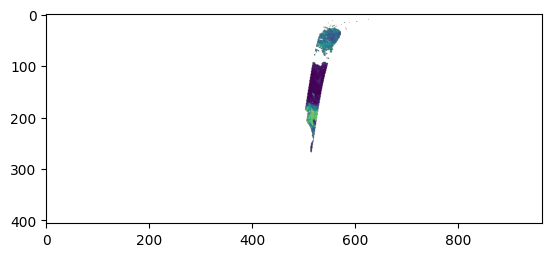

In [14]:
import matplotlib.pyplot as plt

variable = 'soil_moisture'
soil_moisture_data = output_dt['Soil_Moisture_Retrieval_Data'][variable]
plt.imshow(soil_moisture_data)

guess column/row boundaries for the valid data from the above

In [15]:
row_min = 0
row_max = 300
col_min = 400
col_max = 700

# Set the projected limits from the row and column indices

y_coord_min = soil_moisture_data['y-dim'][row_min]
y_coord_max = soil_moisture_data['y-dim'][row_max]
x_coord_min = soil_moisture_data['x-dim'][col_min]
x_coord_max = soil_moisture_data['x-dim'][col_max]

Plot an image with geographic boundaries for the region that has data.

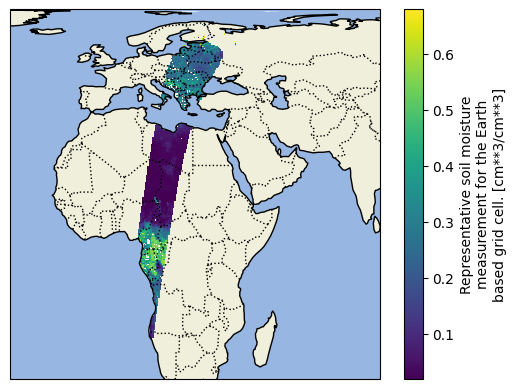

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.epsg(6933)})
ax.set_extent([x_coord_min, x_coord_max, y_coord_min, y_coord_max], crs=ccrs.epsg(6933))
ax.set_title(f'sample plot of {variable}', pad=20, fontsize=14)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')


soil_moisture_data.plot(ax=ax, transform=ccrs.epsg(6933))


plt.show()